In [9]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml


In [10]:
DATASET_PATH = "/Users/mohmsaad/Code/slam/vicon_room1/V1_01_easy/mav0"
CAM0 = os.path.join(DATASET_PATH, "cam0")
CAM1 = os.path.join(DATASET_PATH, "cam1")

In [12]:
# Load images
# First load timestamps.
ts = pd.read_csv(os.path.join(CAM0, 'data.csv'))

print(ts)

          #timestamp [ns]                 filename
0     1403715273262142976  1403715273262142976.png
1     1403715273312143104  1403715273312143104.png
2     1403715273362142976  1403715273362142976.png
3     1403715273412143104  1403715273412143104.png
4     1403715273462142976  1403715273462142976.png
...                   ...                      ...
2907  1403715418612143104  1403715418612143104.png
2908  1403715418662142976  1403715418662142976.png
2909  1403715418712143104  1403715418712143104.png
2910  1403715418762142976  1403715418762142976.png
2911  1403715418812143104  1403715418812143104.png

[2912 rows x 2 columns]


In [40]:
# Load in camera calibration, undistort + rectify stereo images
# requires us to compute the stereo baseline


def load_sensor_data(path):
    with open(path, 'r') as f:
        data = yaml.safe_load(f)
    T = np.array(data['T_BS']['data']).reshape(4, 4)
    K_coeff = data['intrinsics']
    K = np.array([
        [K_coeff[0],  0, K_coeff[2]],
        [ 0, K_coeff[1], K_coeff[3]],
        [ 0,  0,  1]
    ])
    distortion = np.array(data['distortion_coefficients'])
    resolution = data['resolution']
    return T, K, distortion, resolution

T_BS_cam0, K_L, dist_L, res_L = load_sensor_data(os.path.join(CAM0, "sensor.yaml"))
T_BS_cam1, K_R, dist_R, res_R = load_sensor_data(os.path.join(CAM1, "sensor.yaml"))

# cam0 → cam1
T_cam1_cam0 = np.linalg.inv(T_BS_cam1) @ T_BS_cam0

baseline = np.linalg.norm(T_cam1_cam0[:3, 3])
print(f"Stereo baseline: {baseline:.4f} meters")

Stereo baseline: 0.1101 meters


In [68]:
def create_stereo_rect_maps(T_cam1_cam0, K_L, K_R, dist_L, dist_R, resolution):
    """Create stereo rectification maps"""
    R = T_cam1_cam0[0:3, 0:3]   # from extrinsics
    T = T_cam1_cam0[:3, 3]   # translation vector

    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify( \
            K_L, dist_L, K_R, dist_R, resolution, R, T)
    
    map1x, map1y = cv2.initUndistortRectifyMap(
        K_L, dist_L, R1, P1, resolution, cv2.CV_32FC1
    )
    map2x, map2y = cv2.initUndistortRectifyMap(
        K_R, dist_R, R2, P2, resolution, cv2.CV_32FC1
    )

    return {"left": (map1x, map1y), "right": (map2x, map2y)}



(480, 752)


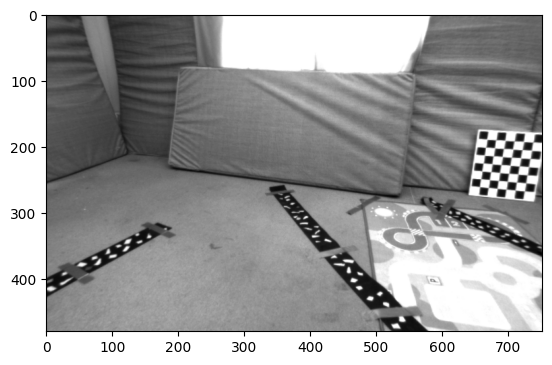

In [79]:
img_L = cv2.imread(os.path.join(CAM0, "data", ts['filename'][0]), cv2.IMREAD_GRAYSCALE)
img_R = cv2.imread(os.path.join(CAM1, "data", ts['filename'][0]), cv2.IMREAD_GRAYSCALE)

maps = create_stereo_rect_maps(T_cam1_cam0, K_L, K_R, dist_L, dist_R, res_L)

# apply map to each image
imgL_rect = cv2.remap(img_L, maps["left"][0], maps["left"][1], cv2.INTER_LINEAR)
imgR_rect = cv2.remap(img_R, maps["right"][0], maps["right"][1], cv2.INTER_LINEAR)

# visualize
plt.imshow(imgL_rect, cmap='gray')

In [82]:
img_L = imgL_rect
img_R = imgR_rect

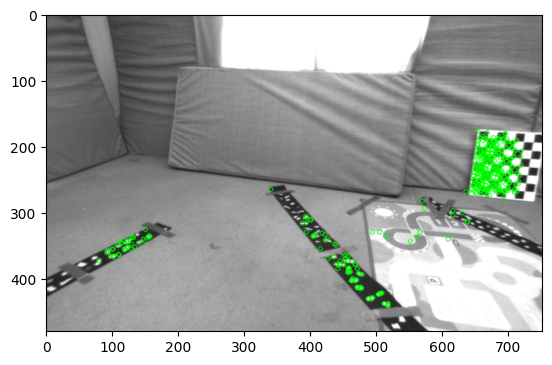

In [84]:
# ORB detector -- compute features and visualize

def extract_orb_features(image: np.ndarray, orb: 'cv2.ORB', visualize: bool = False):
    # find the keypoints with ORB
    kp = orb.detect(image,None)
     
    # compute the descriptors with ORB
    kp, des = orb.compute(image, kp)

    if visualize:
        # draw only keypoints location,not size and orientation
        img2 = cv2.drawKeypoints(image, kp, None, color=(0,255,0), flags=0)
        plt.imshow(img2)

    return kp, des

kp_L, des_L = extract_orb_features(img_L, cv2.ORB_create(), visualize=True)
kp_R, des_R = extract_orb_features(img_R, cv2.ORB_create())

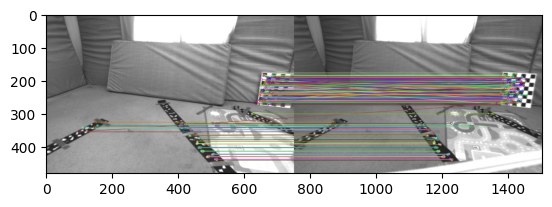

In [85]:
# ORB matcher -- match across keyframes

def match_descriptors(des1, des2):
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
     
    # Match descriptors.
    matches = bf.match(des1,des2)

    return matches

def visualize_matches(img1, kp1, des1, img2, kp2, des2, matches):
    """Visualizes matches between two sets of images"""
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3)


matches = match_descriptors(des_L, des_R)
visualize_matches(img_L, kp_L, des_L, img_R, kp_R, des_R, matches)



Stereo matches after filtering: 113


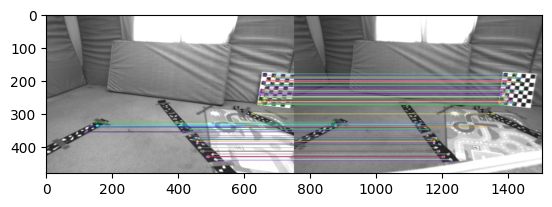

In [101]:

def lowes_ratio_test(matches, ratio=0.75):
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

def epipolar_filter(matches, kp_L, kp_R, max_v_diff=2.0):
    filtered = []
    for m in matches:
        _, vL = kp_L[m.queryIdx].pt
        _, vR = kp_R[m.trainIdx].pt

        if abs(vL - vR) < max_v_diff:
            filtered.append(m)
    return filtered

def disparity_filter(matches, kp_L, kp_R, min_disp=1.0):
    filtered = []
    for m in matches:
        uL, _ = kp_L[m.queryIdx].pt
        uR, _ = kp_R[m.trainIdx].pt

        if (uL - uR) > min_disp:
            filtered.append(m)
    return filtered


def filter_matches(kp_L, des_L, kp_R, des_R):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches_knn = bf.knnMatch(des_L, des_R, k=2)
    
    matches = lowes_ratio_test(matches_knn, ratio=0.75)
    matches = epipolar_filter(matches, kp_L, kp_R, max_v_diff=2.0)
    matches = disparity_filter(matches, kp_L, kp_R, min_disp=1.0)

    return matches

print(f"Stereo matches after filtering: {len(matches)}")
visualize_matches(img_L, kp_L, des_L, img_R, kp_R, des_R, matches)

In [111]:
def has_motion(matches, kpL, kpR, disp_thresh=0.5):
    disparities = []
    for m in matches:
        uL, _ = kpL[m.queryIdx].pt
        uR, _ = kpR[m.trainIdx].pt
        disparities.append(uL - uR)
    return np.mean(np.abs(disparities)) > disp_thresh

    

In [95]:
# extract depth from each match

def compute_depth(matches, kp_L, kp_R, K, baseline):
    """
    Compute a list of 3D points in the cam0 frame.
    
    Args:
        matches: keypoint matches from the matching system
        kp_L: keypoints from cam0 image
        kp_R: keypoints from cam1 image
        K: camera intrinsics matrix of the left camera
        baseline: stereo baseline
    """
    points = []
    for m in matches:
        # compute disparity
        u_L, v_L = kp_L[m.queryIdx].pt
        u_R, v_R = kp_R[m.trainIdx].pt
        
        disp = u_L - u_R

        # compute 3D point
        z = K[0, 0] * baseline / disp
        x = (u_L - K[0, 2]) * z / K[0, 0]
        y = (v_L - K[1, 2]) * z / K[1, 1]

        points.append([x,y,z])

    return np.vstack(points)

pts = compute_depth(matches, kp_L, kp_R, K_L, baseline)
print(pts.shape)

(113, 3)


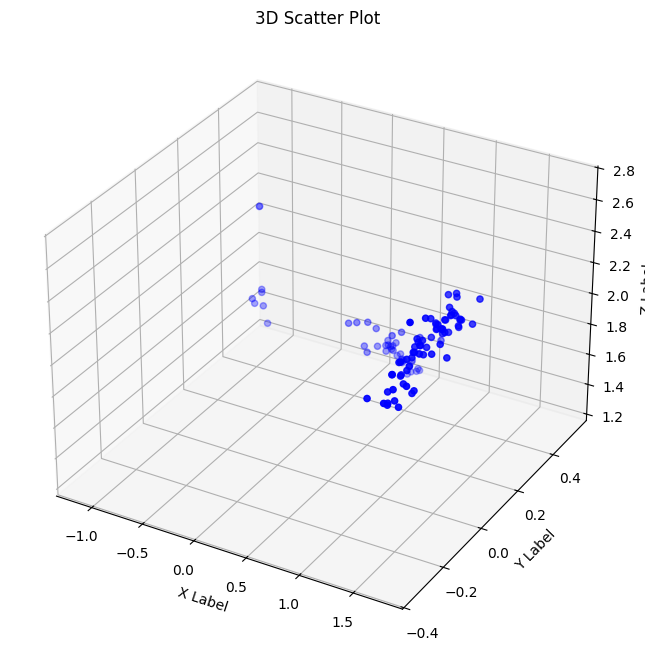

In [94]:
# visualize resulting points
from mpl_toolkits.mplot3d import Axes3D

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Your 3D points (x, y, z coordinates)
x = pts[:, 0]
y = pts[:, 1]
z = pts[:, 2]

# Create scatter plot
ax.scatter(x, y, z, c='blue', marker='o')

# Labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')

plt.show()

In [113]:
# Entire depth estimation pipeline per pair of frames
import time

def frame_iterator(timestamps: pd.DataFrame, maps: dict):
    for filename in timestamps['filename']:
        img_L = cv2.imread(os.path.join(CAM0, "data", filename), cv2.IMREAD_GRAYSCALE)
        img_R = cv2.imread(os.path.join(CAM1, "data", filename), cv2.IMREAD_GRAYSCALE)
        
        imgL_rect = cv2.remap(img_L, maps["left"][0], maps["left"][1], cv2.INTER_LINEAR)
        imgR_rect = cv2.remap(img_R, maps["right"][0], maps["right"][1], cv2.INTER_LINEAR)

        yield imgL_rect, imgR_rect


ts = pd.read_csv(os.path.join(CAM0, 'data.csv'))

def compute_point_cloud_per_frame():
    point_frames = []
    for idx, (imgL, imgR) in enumerate(frame_iterator(ts, maps)):
        
        orb = cv2.ORB_create()
        
        kp_L, des_L = extract_orb_features(img_L, orb)
        kp_R, des_R = extract_orb_features(img_R, orb)
        matches = filter_matches(kp_L, des_L, kp_R, des_R)

        if not has_motion(matches, kp_L, kp_R):
            continue

        points = compute_depth(matches, kp_L, kp_R, K_L, baseline)
        point_frames.append(points)
        if points.shape[0] == 0:
            print(idx)

    return point_frames
        
        
point_frames = compute_point_cloud_per_frame()
print(len(point_frames))


2912


## Compute Rigid Body Transforms

In [108]:
# Use RANSAC to estimate the pose transform between each set of points
# We have to use keyframes for this.
# For this, we will sample once a second from our array, and estimate motion.
# if motion is not enough, skip the current keyframe.

def estimate_relative_pose_svd(P, Q):
    """
    Estimate rigid transform T such that:
        Q ≈ R @ P + t

    Args:
        P: (N, 3) array of 3D points at time k-1
        Q: (N, 3) array of 3D points at time k

    Returns:
        R: (3, 3) rotation matrix
        t: (3,) translation vector
    """
    assert P.shape == Q.shape
    assert P.shape[1] == 3

    # 1. Compute centroids
    p_mean = P.mean(axis=0)
    q_mean = Q.mean(axis=0)

    # 2. Center the points
    P_centered = P - p_mean
    Q_centered = Q - q_mean

    # 3. Compute covariance matrix
    H = P_centered.T @ Q_centered

    # 4. SVD
    U, S, Vt = np.linalg.svd(H)

    # 5. Compute rotation
    R = Vt.T @ U.T

    # Handle improper rotation (reflection)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # 6. Compute translation
    t = q_mean - R @ p_mean

    return R, t


def estimate_pose_ransac(P, Q, num_iters=1000, threshold=0.05):
    """
    Robust relative pose estimation using RANSAC.

    Args:
        P: (N, 3) source points
        Q: (N, 3) target points
        threshold: inlier distance threshold (meters)

    Returns:
        best_R, best_t, inlier_mask
    """
    assert len(P) >= 3

    best_inliers = []
    best_R, best_t = None, None

    N = len(P)

    for _ in range(num_iters):
        # Random minimal sample
        idx = np.random.choice(N, 3, replace=False)
        R, t = estimate_relative_pose_svd(P[idx], Q[idx])

        # Transform all points
        P_transformed = (R @ P.T).T + t

        # Compute residuals
        errors = np.linalg.norm(Q - P_transformed, axis=1)
        inliers = errors < threshold

        if inliers.sum() > len(best_inliers):
            best_inliers = inliers
            best_R, best_t = R, t

    # Refit using all inliers
    if best_R is not None:
        best_R, best_t = estimate_relative_pose_svd(
            P[best_inliers], Q[best_inliers]
        )

    return best_R, best_t, best_inliers

def make_transform(R, t):
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T



T_t0_t1 = [np.eye(4)]
dead_reckoning = [np.eye(4)]
T_global = np.eye(4)
for idx in range(1, len(point_frames)):
    R, t, inliers = estimate_pose_ransac(point_frames[idx-1], point_frames[idx])

    print(f"{idx}--Inliers: {inliers.sum()} -- Translation norm: {np.linalg.norm(t)} -- angle: {np.degrees(np.arccos((np.trace(R) - 1) / 2))}")

    
    T_next = make_transform(R, t)
    T_t0_t1.append(T_next)
    T_global = T_global @ T_next
    dead_reckoning.append(T_global)


    
    


1--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
2--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
3--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
4--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
5--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
6--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
7--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
8--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
9--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
10--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
11--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
12--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
13--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
14--Inliers: 113 -- Translation no

/var/folders/wp/s1j42rp914vfjtz7rg7wlksh0000gq/T/ipykernel_34245/2079573076.py:104: RuntimeWarning: invalid value encountered in arccos
  print(f"{idx}--Inliers: {inliers.sum()} -- Translation norm: {np.linalg.norm(t)} -- angle: {np.degrees(np.arccos((np.trace(R) - 1) / 2))}")


20--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
21--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
22--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
23--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
24--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
25--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
26--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
27--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
28--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
29--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
30--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
31--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
32--Inliers: 113 -- Translation norm: 1.2994827337208943e-15 -- angle: nan
33--Inliers: 113 -- Trans